# Kaggle's [Titanic competition](https://www.kaggle.com/competitions/titanic) solution.

Objective: Beat the score of 0.76555 of acurracy in the predictions of who survives the disaster, and do this using GridSearchCV with Pipeline. This score is obtained by assuming that all men die and women survive. 

Methodology: In order to get a good score I used several data preparation technics, such as imputation, encoders, feature selection, data scale, changes in the distibution and so on, I also tried a few classifications algorithms. In this project you will see the combination of technics tested that resulted in the best peformance.



### 1. Analysing and understanding the data

In [1]:
import pandas as pd
import numpy as np
import os

In [9]:
project_dir = os.path.dirname( os.path.dirname( os.path.abspath( "-" ) ) )
data_dir = os.path.join( os.path.join( project_dir, "original data" ), "train.csv" )

In [10]:
df = pd.read_csv(data_dir)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [12]:
#looking for missing values
for i in df.columns:
  # count number of rows with missing values
  n_miss = df[[i]].isnull().sum()
  perc = n_miss / df.shape[0] * 100
  print('> %s, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> PassengerId, Missing: 0 (0.0%)
> Survived, Missing: 0 (0.0%)
> Pclass, Missing: 0 (0.0%)
> Name, Missing: 0 (0.0%)
> Sex, Missing: 0 (0.0%)
> Age, Missing: 177 (19.9%)
> SibSp, Missing: 0 (0.0%)
> Parch, Missing: 0 (0.0%)
> Ticket, Missing: 0 (0.0%)
> Fare, Missing: 0 (0.0%)
> Cabin, Missing: 687 (77.1%)
> Embarked, Missing: 2 (0.2%)


The first conclusion is that we can know for sure that some columns of the dataset are not important to build a model, they are: 


*   PassengerId
*   Name
*   Cabin


---


We can see that there are a lot of missing values in the **Sex** column and 2 missing in the column **Embarked**. I might apply a imputation technique to deal with the **Sex** column, but, since there are only two missing values in the **Embarked** columns I decided to drop the rows with missing values.



In [13]:
df.dropna(subset=["Embarked"], inplace=True)



---


Now let's start a statistical analysis and select only the relevant columns.

In [14]:
df.describe().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.0,889.00,889.00,712.00,889.00,889.00,889.00
mean,446.0,0.38,2.31,29.64,0.52,0.38,32.10
std,257.0,0.49,0.83,14.49,1.10,0.81,49.70
min,1.0,0.00,1.00,0.42,0.00,0.00,0.00
25%,224.0,0.00,2.00,20.00,0.00,0.00,7.90
50%,446.0,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.0,1.00,3.00,38.00,1.00,0.00,31.00
max,891.0,1.00,3.00,80.00,8.00,6.00,512.33


In [15]:
df.describe(include = ['category','object'])

,Name,Sex,Ticket,Cabin,Embarked
count,889,889,889,202,889
unique,889,2,680,146,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [16]:
#columns selected
X = df[["Pclass", "Sex", "Age", "SibSp","Parch", "Fare", "Embarked"]] #features
y = df["Survived"] #target variable


I use get_dummies pandas method to deal with the categorical(not ordinal) variables, I do this setting the *drop_first* parameter as True to remove the redundancies. Note that, in the DataFrame below, there is no columns for Sex_female or Embarked_C, the model will know when it is Embarked_C when Embarked_Q and Embarked_S are 0 for example.

In [17]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


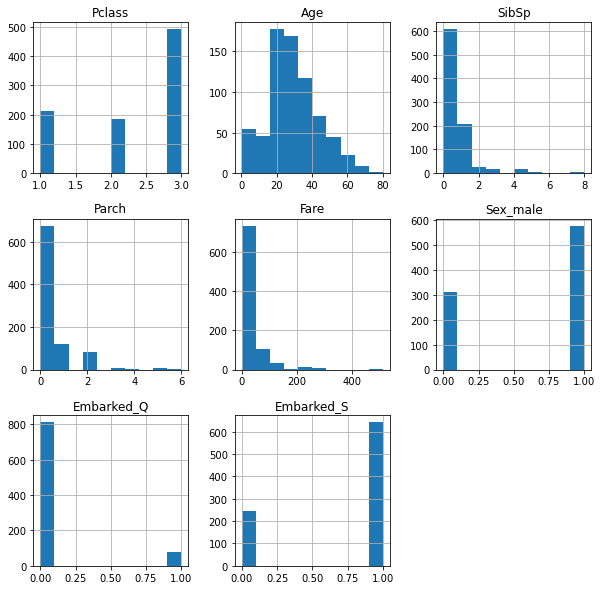

In [18]:
X.hist(xlabelsize=10, ylabelsize=10, figsize=(10, 10));


In [19]:
num_pass_less_19 = len(X[ (X.Age<=19) ])
perc_pass_less_19 = round(num_pass_less_19/len(X)*100,2)

print(perc_pass_less_19,"%")

18.45 %


**Insights**
* About 38% of the people in this dataset died in the disaster
* There are many missing ages, I may have to apply some imputation technic. But from the available ages we know that the mean age is 26 and 18.45% of the passangers were teenagers or children.
* About 65% of the people were male, and as we know, most of the people who died were male, as women and children had priority to be saved.
* About 72% of the passengers embarked in Southampton, witch is the city that the Titanic sailed out of.

### 2. Data Preparation and algorithm choice

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

The applied steps for data preparation are:
1. Imputation: KNNImputer to impute the missing ages using K-nearest neighbors
2. Scaler: RobustScaler to scale the data with robust approach to dealing with outliers
3. Feature Selection: RFE, feature ranking with recursive feature elimination, using DecisionTreeClassifier as estimator to score the best features

---

Three algothms were tested:
1. Support Vector Classification
2. Gaussian Naive Bayes
3. Random Forest Classifier

A pipeline with all steps was created. With the GridSeachCV many combinations of hyper parameters were tested to find out which combination of parameters raises the best score.

In [13]:
#Support Vector Classification

pl = Pipeline(steps = [
                      ("imputer", KNNImputer()),
                      ("scaler", RobustScaler()),
                       ("feature", RFE(estimator=DecisionTreeClassifier())),
                       ("algorithm", SVC())
])

parameters = {"imputer__n_neighbors":[8, 9, 10],
              "scaler__quantile_range":[(20,80),(10,90),(25,75)],
              "feature__n_features_to_select":[ 6, 7, 8],
              "algorithm__tol":[0.001, 0.0001],
              "algorithm__C":[1, 1.5],
              "algorithm__kernel":["rbf", "linear", "poly", "sigmoid"]}

grid_search = GridSearchCV(estimator = pl, param_grid = parameters, n_jobs=-1, verbose=2)
grid_search.fit(X,y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
{'algorithm__C': 1.5, 'algorithm__kernel': 'poly', 'algorithm__tol': 0.001, 'feature__n_features_to_select': 7, 'imputer__n_neighbors': 8, 'scaler__quantile_range': (10, 90)}
0.8268139402018664


In [17]:
#Gaussian Naive Bayes

pl = Pipeline(steps = [
                      ("imputer", KNNImputer()),
                      ("scaler", RobustScaler()),
                       ("feature", RFE(estimator=DecisionTreeClassifier())),
                       ("algorithm", GaussianNB())
])

parameters = {"imputer__n_neighbors":[8, 9, 10],
              "feature__n_features_to_select":[ 6, 7, 8],
              "scaler__quantile_range":[(20,80),(10,90),(25,75)]}

grid_search = GridSearchCV(estimator = pl, param_grid = parameters, n_jobs=-1, verbose=2)
grid_search.fit(X,y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'feature__n_features_to_select': 7, 'imputer__n_neighbors': 8, 'scaler__quantile_range': (10, 90)}
0.7896591125499905


In [26]:
#RandomForestClassifier

pl = Pipeline(steps = [
                      ("imputer", KNNImputer()),
                      ("scaler", RobustScaler()),
                       ("feature", RFE(estimator=DecisionTreeClassifier())),
                       ("algorithm", RandomForestClassifier())
])

parameters = {"imputer__n_neighbors":[8, 9, 10],
              "feature__n_features_to_select":[ 6, 7, 8],
              "algorithm__n_estimators":[25,50,75],
              "scaler__quantile_range":[(20,80),(10,90),(25,75)]}

grid_search = GridSearchCV(estimator = pl, param_grid = parameters, n_jobs=-1, verbose=2)
grid_search.fit(X,y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'algorithm__n_estimators': 75, 'feature__n_features_to_select': 8, 'imputer__n_neighbors': 9, 'scaler__quantile_range': (25, 75)}
0.8211832666793628


---
After finding the best cobination of parameters let's build some models with those parameters and avaliate them one more time with 10-Fold Cross Validation

In [29]:
SVC_model = Pipeline(steps = [
                      ("imputer", KNNImputer(n_neighbors=8)),
                      ("scaler", RobustScaler(quantile_range=(10,90))),
                       ("feature", RFE(estimator=DecisionTreeClassifier(),n_features_to_select=7)),
                       ("algorithm", SVC(C=1.5,kernel = "poly",tol = 0.001 ))
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(SVC_model, X, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



Mean Accuracy: 0.816 (0.042)


In [30]:
GaussianNB_model = Pipeline(steps = [
                      ("imputer", KNNImputer(n_neighbors=8)),
                      ("scaler", RobustScaler(quantile_range=(10,90))),
                       ("feature", RFE(estimator=DecisionTreeClassifier(),n_features_to_select=7)),
                       ("algorithm", GaussianNB())
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(GaussianNB_model, X, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Mean Accuracy: 0.784 (0.045)


In [33]:
RandomForestClassifier_model = Pipeline(steps = [
                      ("imputer", KNNImputer(n_neighbors=9)),
                      ("scaler", RobustScaler(quantile_range=(25,75))),
                       ("feature", RFE(estimator=DecisionTreeClassifier(),n_features_to_select=8)),
                       ("algorithm", RandomForestClassifier(n_estimators=75))
])

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(RandomForestClassifier_model, X, y, scoring='accuracy', cv=cv)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Mean Accuracy: 0.812 (0.042)


---
Let's now write a function to create a csv file to submit to kaggle's competition.

In [41]:
def create_submission(model, filename):
    project_dir = os.path.dirname( os.path.dirname( os.path.abspath( "-" ) ) )
    data_test_dir = os.path.join( os.path.join( project_dir, "original data" ), "test.csv" )
    df_test = pd.read_csv(data_test_dir)

    #columns selected
    X_test = df_test[["Pclass", "Sex", "Age", "SibSp","Parch", "Fare", "Embarked"]]
    X_test = pd.get_dummies(X_test, drop_first=True)
    yhat = model.predict(X_test)
    
    yhat = pd.Series(yhat, name="Survived")
    df_result = pd.concat([df_test["PassengerId"], yhat], axis= 1 )
    
    file_path = os.path.join( os.path.join( project_dir, "submissions" ), filename )
    df_result.to_csv(file_path,index=False)

In [42]:
SVC_model.fit(X,y)
GaussianNB_model.fit(X,y)
RandomForestClassifier_model.fit(X,y)
create_submission(SVC_model,"SVC_submission.csv")
create_submission(GaussianNB_model,"GaussianNB_submission.csv")
create_submission(RandomForestClassifier_model,"RandomForestClassifier_submission.csv")

The image below shows the results for the 3 submissions, the only one that reached the goal was the SVC model

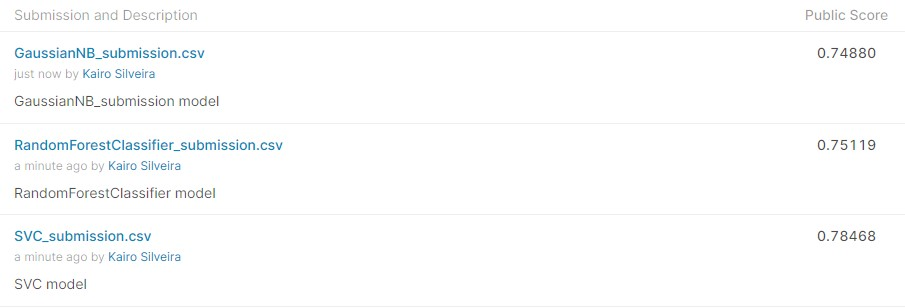